## SVM-based methods for classification
This tutorial is meant to be an introduction to SVM-based methods for classification. We start with the linear basic model.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import datasets

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

plt.rcParams.update({'font.size': 20})

In [2]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return matplotlib.colors.LinearSegmentedColormap('CustomMap', cdict)

def plot_model_pred_2d(mdl, X, y, feat, cm=None):
    # look at the regions in a 2d plot
    # based on scikit-learn tutorial plot_iris.html
    
    # get minimum and maximum values
    x0_min = X[:, 0].min()-1
    x0_max = X[:, 0].max()+1
    x1_min = X[:, 1].min()-1
    x1_max = X[:, 1].max()+1

    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                         np.linspace(x1_min, x1_max, 100))

    Z = mdl.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    
    if not cm:
        # custom colormap
        #e58139f9 - orange
        #399de5e0 - to blue
        s = list()

        lo = np.array(matplotlib.colors.to_rgb('#e5813900'))
        hi = np.array(matplotlib.colors.to_rgb('#399de5e0'))

        for i in range(255):
            s.append( list((hi-lo)*(float(i)/255)+lo) )
        cm = make_colormap(s)
    
    # plot the contour - colouring different regions
    cs = plt.contourf(xx, yy, Z, cmap=cm)

    # plot the individual data points - colouring by the *true* outcome
    color = y.ravel()
    plt.scatter(X[:, 0], X[:, 1], c=color, edgecolor='k', linewidth=2,
                marker='o', s=60, cmap=cm)

    plt.xlabel(feat[0])
    plt.ylabel(feat[1])
    plt.axis("tight")
    #plt.clim([-1.5,1.5])
    plt.colorbar()
    

def create_graph(mdl, cmap=None):
    # cmap is a colormap
    # e.g. cmap = matplotlib.cm.coolwarm( np.linspace(0.0, 1.0, 256, dtype=float) )
    tree_graph = tree.export_graphviz(mdl, out_file=None,
                             feature_names=feat, 
                             filled=True, rounded=True)
    graph = pydotplus.graphviz.graph_from_dot_data(tree_graph)
    
    # get colormap
    if cmap:
        # remove transparency
        if cmap.shape[1]==4:
            cmap = cmap[:,0:2]
        
        nodes = graph.get_node_list()
        for node in nodes:
            if node.get_label():
                # get number of samples in group 1 and group 2
                num_samples = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]

                # proportion that is class 2
                cm_value = float(num_samples[1]) / float(sum(num_samples))
                # convert to (R, G, B, alpha) tuple
                cm_value = matplotlib.cm.coolwarm(cm_value)
                cm_value = [int(np.ceil(255*x)) for x in cm_value]
                color = '#{:02x}{:02x}{:02x}'.format(cm_value[0], cm_value[1], cm_value[2])
                node.set_fillcolor(color)

    Image(graph.create_png())
    return graph

### Dataset
Import the dataset, and check its properties!

In [55]:
# real example
df = datasets.load_iris()
# if you want a description of the dataset, uncomment the below line
print(df['DESCR'])

idx = [0,2]
X = df['data'][50:,idx]
y = df['target'][50:]

# recode target as -1 and 1
y[y==1] = 0
y[y==2] =  1

feat = [df['feature_names'][x] for x in idx]

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

### Support Vector Machine
Lets build a first model using a linear kernel.

In [35]:
# instantiate an instance of our tree with the parameters we would like
mdl = svm.SVC(kernel='linear', C=100, gamma=1, probability=True)

# fit the model to the data - trying to predict y from X
mdl = mdl.fit(X,y)

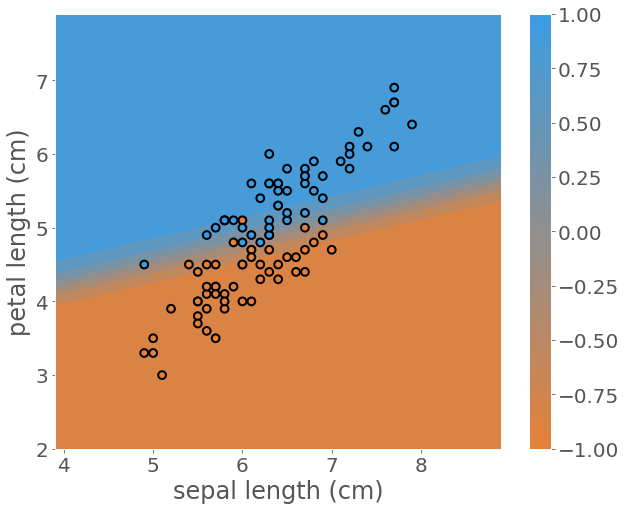

In [36]:
# look at the regions in a 2d plot
# based on scikit-learn tutorial plot_iris.html
plt.figure(figsize=[10,8])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

**C**: Penalty parameter C of the error term. It also controls the trade off between smooth decision boundary and classifying the training points correctly.

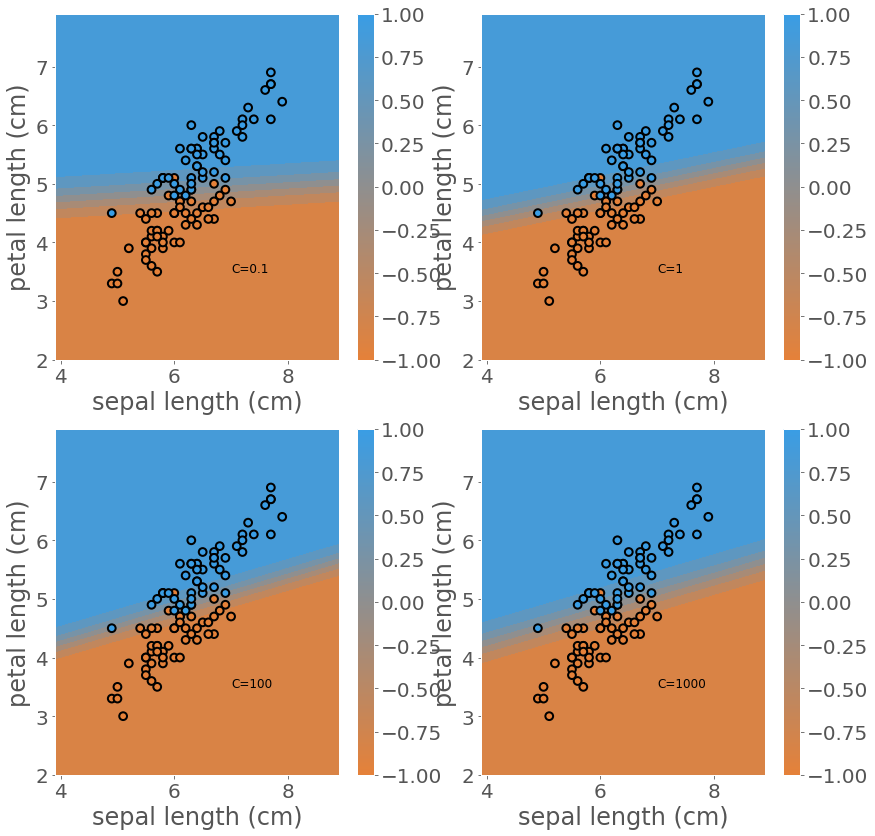

In [49]:
fig = plt.figure(figsize=[14,14])
Cc = [0.1, 1, 100, 1000]

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    # set different C values
    mdl = svm.SVC(kernel='linear', C=Cc[i], probability=True).fit(X, y)
    plot_model_pred_2d(mdl, X, y, feat)
    txt = 'C={}'.format(Cc[i])
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
    
plt.show()

Lets now build with an **RBF** kernel.

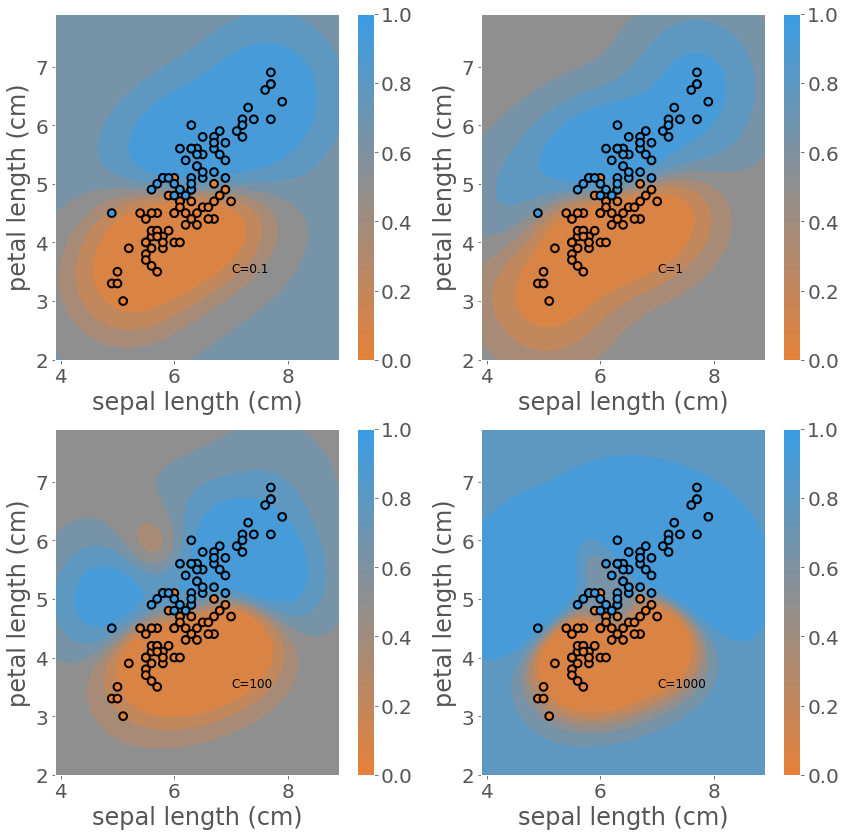

In [56]:
fig = plt.figure(figsize=[14,14])
Cc = [0.1, 1, 100, 1000]

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    # set different C values
    mdl = svm.SVC(kernel='rbf', C=Cc[i], gamma=1, probability=True).fit(X, y)
    plot_model_pred_2d(mdl, X, y, feat)
    txt = 'C={}'.format(Cc[i])
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
    
plt.show()

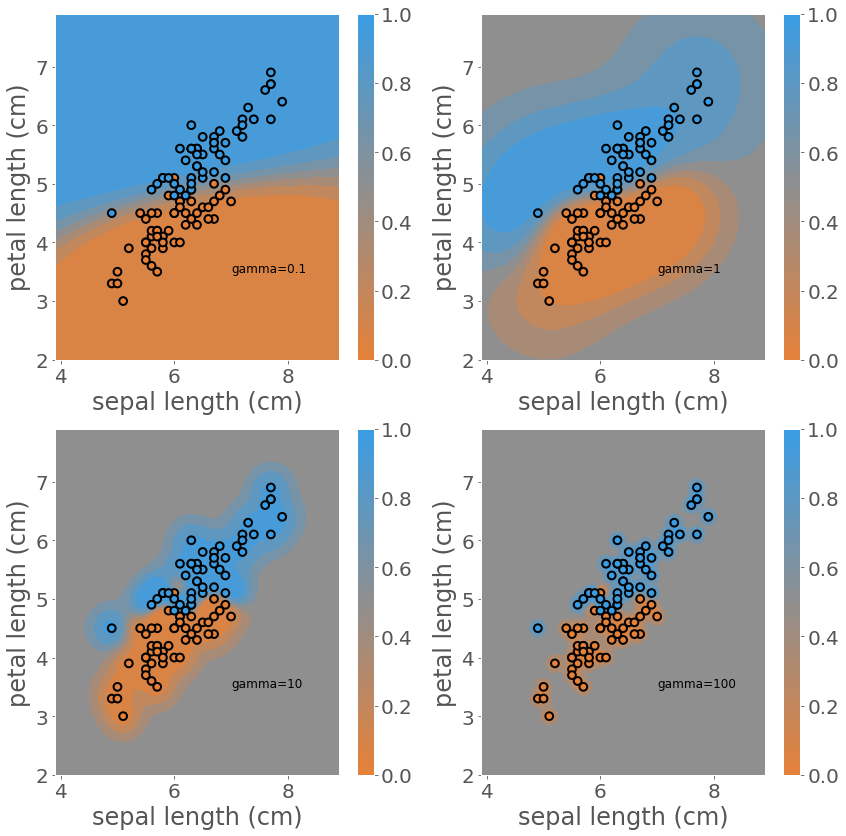

In [58]:
fig = plt.figure(figsize=[14,14])
Cc = [0.1, 1, 10, 100]

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    # set different C values
    mdl = svm.SVC(kernel='rbf', C=10, gamma=Cc[i], probability=True).fit(X, y)
    plot_model_pred_2d(mdl, X, y, feat)
    txt = 'gamma={}'.format(Cc[i])
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
    
plt.show()